In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf

tf.__version__

'2.6.0'

In [3]:
tf.test.gpu_device_name()

''

In [4]:
# 1. Boston_Housing Data_Set Load & Review

from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (X_test, y_test) = boston_housing.load_data()

In [5]:
print(train_data.shape)
print(X_test.shape)

print(train_targets[:10])
print(y_test[:10])

(404, 13)
(102, 13)
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4]
[ 7.2 18.8 19.  27.  22.2 24.5 31.2 22.9 20.5 23.2]


In [6]:
# 2. Data Preprocessing

mean = train_data.mean(axis = 0)
std = train_data.std(axis = 0)

train_data = train_data - mean
train_data = train_data / std

X_test = X_test - mean
X_test = X_test / std

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_targets,
                                                      test_size=0.2,
                                                      random_state=2045)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((323, 13), (81, 13), (323,), (81,))

In [8]:
# 3. Boston_Housing Keras Modeling

from tensorflow.keras import models, layers

boston = models.Sequential(name = 'Regression')
boston.add(layers.Dense(64, activation='relu', input_shape=(13,)))
boston.add(layers.Dense(64, activation='relu'))
boston.add(layers.Dense(1))

In [9]:
boston.summary()

Model: "Regression"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


In [10]:
boston.compile(loss = 'mse',
               optimizer = 'rmsprop',
               metrics = ['mae'])

In [11]:
%%time

Hist_boston = boston.fit(X_train, y_train,
                         epochs=500,
                         batch_size=1,
                         validation_data = (X_valid, y_valid))

Epoch 1/500
323/323 [==============================] - 1s 2ms/step - loss: 223.4502 - mae: 11.2369 - val_loss: 49.3997 - val_mae: 4.3035
Epoch 2/500
323/323 [==============================] - 0s 1ms/step - loss: 26.3492 - mae: 3.6682 - val_loss: 31.5629 - val_mae: 3.4161
Epoch 3/500
323/323 [==============================] - 0s 1ms/step - loss: 18.4805 - mae: 3.0412 - val_loss: 27.8942 - val_mae: 3.2626
Epoch 4/500
323/323 [==============================] - 0s 1ms/step - loss: 16.4993 - mae: 2.8041 - val_loss: 21.8748 - val_mae: 2.9981
Epoch 5/500
323/323 [==============================] - 0s 1ms/step - loss: 14.6532 - mae: 2.6249 - val_loss: 24.6026 - val_mae: 2.9557
Epoch 6/500
323/323 [==============================] - 1s 2ms/step - loss: 13.8033 - mae: 2.5190 - val_loss: 20.3906 - val_mae: 2.5611
Epoch 7/500
323/323 [==============================] - 0s 2ms/step - loss: 12.8829 - mae: 2.4550 - val_loss: 20.9619 - val_mae: 2.7290
Epoch 8/500
323/323 [==============================] 

In [12]:
test_mse_score, test_mae_score = boston.evaluate(X_test, y_test)

print('MAE is :', test_mae_score)

4/4 [==============================] - 0s 3ms/step - loss: 12.7628 - mae: 2.4890
MAE is : 2.4890177249908447


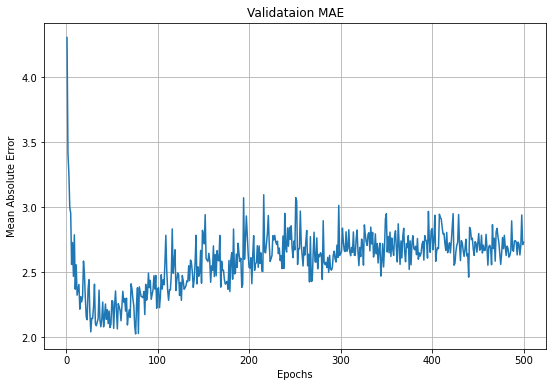

In [13]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_boston.history['val_mae']) + 1)
plt.figure(figsize=(9,6))
plt.plot(epochs, Hist_boston.history['val_mae'])
plt.title('Validataion MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.grid()

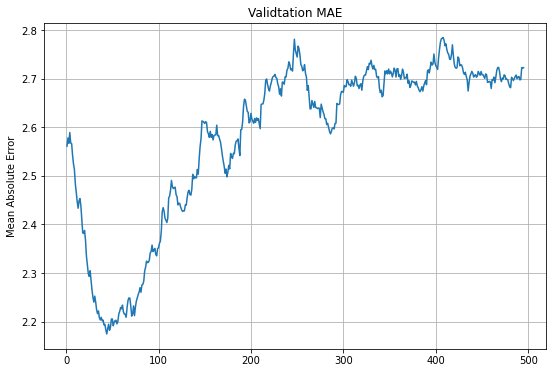

In [14]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

mae_history = Hist_boston.history['val_mae']

mae_history = smooth_curve(mae_history[5:])

plt.figure(figsize=(9,6))
plt.plot(range(1, len(mae_history) + 1), mae_history)
plt.title('Validtation MAE')
plt.ylabel('Mean Absolute Error')
plt.grid()
plt.show()

In [15]:
from tensorflow.keras import backend as K

K.clear_session()

In [16]:
# 4. Early Stopping

from tensorflow.keras import models, layers

boston = models.Sequential(name = 'EarlyStopping')
boston.add(layers.Dense(64, activation='relu', input_shape=(13,)))
boston.add(layers.Dense(64, activation='relu'))
boston.add(layers.Dense(1))

boston.compile(loss = 'mse',
               optimizer = 'rmsprop',
               metrics = ['mae'])

In [17]:
# monitor : 모니터링 대상의 성능
# mode : 모니터링 대상을 최소화(Min) 또는 최대화(Max)
# patience : 성능이 개선되지 않는 epoch 횟수

from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor = 'val_mae',
                   mode = 'min',
                   patience = 50,
                   verbose = 1)

In [18]:
# 'best_boston.h5' : 최적모델이 저장될 경로
# save_best_only : 최적모델만 저장할지 지정

from tensorflow.keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint('best_boston.h5',
                     monitor = 'val_mae',
                     mode = 'min',
                     save_best_only = True,
                     verbose = 1)

In [19]:
# callbacks : EarlyStopping() 과 ModelCheckpoint() 객체를 지정

%%time
Hist_boston = boston.fit(X_train, y_train,
                         epochs = 500,
                         batch_size = 1,
                         validation_data = (X_valid, y_valid),
                         callbacks = [es, mc],
                         verbose = 1)

Epoch 1/500
323/323 [==============================] - 1s 2ms/step - loss: 224.4604 - mae: 10.8687 - val_loss: 48.2264 - val_mae: 4.3441

Epoch 00001: val_mae improved from inf to 4.34411, saving model to best_boston.h5
Epoch 2/500
323/323 [==============================] - 0s 1ms/step - loss: 27.7352 - mae: 3.7293 - val_loss: 30.1402 - val_mae: 2.9886

Epoch 00002: val_mae improved from 4.34411 to 2.98857, saving model to best_boston.h5
Epoch 3/500
323/323 [==============================] - 0s 1ms/step - loss: 20.0931 - mae: 3.1022 - val_loss: 26.3984 - val_mae: 2.7657

Epoch 00003: val_mae improved from 2.98857 to 2.76569, saving model to best_boston.h5
Epoch 4/500
323/323 [==============================] - 1s 2ms/step - loss: 16.9120 - mae: 2.7751 - val_loss: 20.1224 - val_mae: 2.7986

Epoch 00004: val_mae did not improve from 2.76569
Epoch 5/500
323/323 [==============================] - 0s 1ms/step - loss: 15.2223 - mae: 2.6645 - val_loss: 20.7278 - val_mae: 2.6790

Epoch 00005: v

In [20]:
! ls -l

total 76
-rw-r--r-- 1 root root 70280 Sep 30 03:00 best_boston.h5
drwxr-xr-x 1 root root  4096 Sep 16 13:40 sample_data


In [21]:
from tensorflow.keras.models import load_model

best_boston = load_model('best_boston.h5')

In [22]:
test_mse_score, test_mae_score = best_boston.evaluate(X_test, y_test)

print('MAE is:', test_mae_score)

4/4 [==============================] - 0s 3ms/step - loss: 20.0763 - mae: 2.7972
MAE is: 2.7971861362457275
